In [ ]:
!pip install hdbscan

In [ ]:
from bs4 import BeautifulSoup
from collections import OrderedDict
import numpy as np
import pandas as pd
import requests
import os
import statistics
import time
from IPython.core.display import display, HTML

Download the [@ronanmann](https://twitter.com/ronanmann/status/1408504415690969089) spreadsheet and read it into a DataFrame. Convert all data columns to numeric values.

In [ ]:
!wget -O players.csv "https://docs.google.com/spreadsheets/d/1lQgIDcxsHT1m_IayMldmiHVOt4ICbX-ys8Mh9rggPHM/export?format=csv#gid=2093389914" &>/dev/null

def scrub_strings(s):
  if type(s) == str:
    try:
      return int(s.replace(',', ''))
    except ValueError:
      return 0
  else:
    return s

def apply_to_series(s):
  return s.apply(scrub_strings)

def get_clean_data(df):
  df.fillna(0, inplace=True)
  return df.apply(apply_to_series)

players_df = pd.read_csv('players.csv')
player_data_df = get_clean_data(players_df.iloc[:, 5:])
player_data_df.head()

,Age,Born,MP,Starts,Min,90s,Ast/90,npG/90,npG+A/90,xA/90,npxG/90,npxG+xA/90,Shots/90,SoTs/90,SoT%,Gls/Shot,Gls/SoT,AvgShotDist,FKSht/90,npxG/Shot,np:G-xG,PassCmp/90,PassAtt/90,PassCmp%,TotDistPass/90,PrgDistPass/90,ShortCmp/90,ShortAtt/90,ShortCmp%,MedCmp/90,MedAtt/90,MedCmp%,LongCmp/90,LongAtt/90,LongCmp%,KeyPass/90,PassIntoThird/90,PassIntoBox/90,CrossIntoBox/90,ProgPass/90,...,SuccPress/90,PressSucc%,Def 3rdPress/90,Mid 3rdPress/90,Att 3rdPress/90,Blocks/90,ShotBlocks/90,PassBlk/90,Interceptions/90,Clearances/90,ErrToShot/90,Touches/90,Def PenTchs/90,Def 3rdTchs/90,Mid 3rdTchs/90,Att 3rdTchs/90,Att PenTchs/90,%TchsDefPen,%TchsDefThrd,%TchsMidThrd,%TchsAttThrd,%TchsAttPen,LiveTchs/90,SuccDrib/90,AttDrib/90,DribSucc%,PlayersDribPast/90,Megs/90,Carries/90,TotDistCarry/90,PrgDistCarry/90,ProgCarry/90,CarryIntoThird/90,CarryIntoBox/90,Miscontrol/90,Dispossessed/90,PassTarget/90,PassesReceived/90,PassRec%,ProgPassReceived/90
0,29.0,1990.0,22,20,1777,19.7,0.05,0.00,0.05,0.04,0.06,0.10,0.91,0.30,33.3,0.00,0.0,20.3,0.15,0.07,-0.06,45.1,57.2,78.9,756.6,352.5,23.00,26.00,88.7,17.3,21.2,81.3,3.96,7.66,51.7,0.56,3.45,1.32,0.20,5.69,...,3.50,33.5,6.60,2.84,1.02,1.57,0.36,1.22,1.73,2.03,0.05,67.2,3.65,20.6,32.6,17.50,1.93,0,0,0,0,0,57.2,0.46,1.07,42.9,0.46,0.00,37.2,178.8,96.8,5.79,1.52,0.46,0.66,0.81,42.3,39.3,92.8,2.34
1,32.0,1987.0,33,33,2889,32.1,0.00,0.09,0.09,0.01,0.05,0.06,0.47,0.16,33.3,0.20,0.6,10.2,0.00,0.11,0.04,46.9,53.4,87.8,1049.7,361.9,10.50,11.70,89.1,27.8,29.6,93.9,8.32,11.40,73.0,0.12,2.52,0.03,0.00,2.83,...,4.55,38.5,7.85,3.43,0.53,1.59,0.62,0.97,1.74,5.30,0.00,65.0,8.69,37.5,30.7,1.28,0.65,0,0,0,0,0,63.2,0.37,0.62,60.0,0.40,0.03,41.7,235.5,130.5,1.81,0.25,0.03,0.25,0.47,43.8,42.5,97.0,0.22
2,24.0,1995.0,14,14,1260,14.0,0.00,0.00,0.00,0.00,0.08,0.09,0.93,0.21,23.1,0.00,0.0,11.3,0.00,0.09,-0.09,36.1,44.6,80.9,870.6,313.6,8.93,9.57,93.3,17.3,19.6,88.3,9.43,14.60,64.4,0.21,2.14,0.14,0.00,2.21,...,3.21,42.1,5.21,2.07,0.36,1.14,0.36,0.79,2.29,10.10,0.14,61.1,10.10,37.0,26.4,1.79,1.14,0,0,0,0,0,59.3,0.36,0.43,83.3,0.36,0.00,32.6,215.2,117.9,1.14,0.07,0.00,0.14,0.07,33.7,32.9,97.7,0.00
3,34.0,1986.0,14,14,1222,13.6,0.00,0.07,0.07,0.03,0.05,0.08,0.66,0.15,22.2,0.11,0.5,16.0,0.00,0.07,0.02,41.5,50.7,81.9,888.0,312.8,13.00,15.00,86.8,20.4,22.8,89.4,7.79,11.80,65.8,0.15,3.68,0.22,0.15,3.16,...,4.71,44.4,5.96,3.46,1.18,1.91,0.37,1.54,1.10,2.43,0.00,58.3,4.04,23.7,31.0,7.35,0.59,0,0,0,0,0,54.3,0.22,0.44,50.0,0.29,0.00,32.0,169.9,92.7,3.24,0.66,0.00,0.22,0.00,34.8,33.4,96.0,0.59
4,32.0,1988.0,32,32,2813,31.3,0.03,0.00,0.03,0.03,0.03,0.06,0.26,0.00,0.0,0.00,0.0,13.1,0.00,0.12,-0.03,57.6,65.0,88.6,1234.2,333.6,17.80,19.30,92.2,27.7,29.3,94.4,11.00,14.60,75.4,0.38,3.67,0.64,0.29,3.16,...,4.66,41.8,6.39,3.80,0.96,1.63,0.61,1.02,1.98,5.02,0.03,76.1,11.10,39.3,37.4,6.23,0.61,0,0,0,0,0,72.8,0.35,0.38,91.7,0.35,0.00,46.3,313.3,166.3,3.71,1.02,0.03,0.45,0.26,50.9,49.5,97.3,0.70


Install and import [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html).

In [ ]:
!pip install umap-learn
!pip install umap-learn[plot]

In [ ]:
from sklearn.preprocessing import StandardScaler
import umap
import umap.plot

Since our source is individual player data, unsupervised UMAP lends itself to clustering players by position. Players of similar positions across all leagues are grouped closer together (with goalkeepers creating their own island as would be expected). This is demonstrated by [@TonyElHabr](https://twitter.com/TonyElHabr), and extended to show how position clustering can be improved by training with the position labels and identifying clusters with GMM, in this [article](https://tonyelhabr.rbind.io/post/dimensionality-reduction-and-clustering/)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


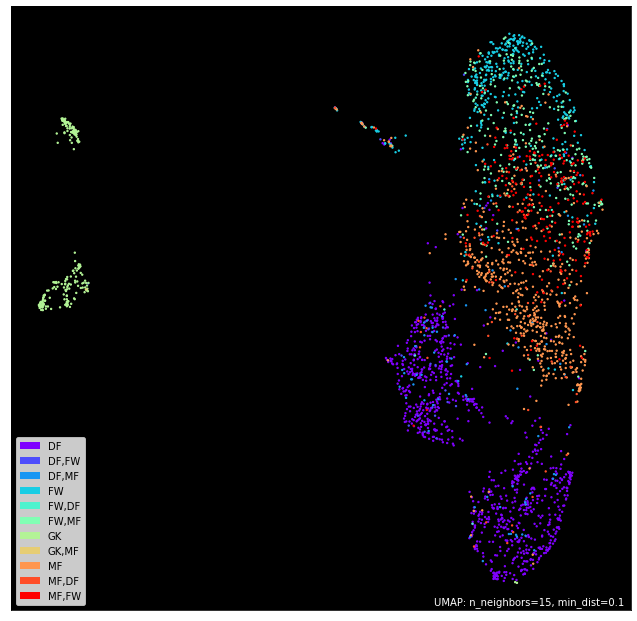

In [ ]:
scaled_player_data = StandardScaler().fit_transform(player_data_df)
u = umap.UMAP()
model_unsupervised = u.fit(scaled_player_data)
umap.plot.points(model_unsupervised, labels=players_df['Pos'], theme='fire')

But, what happens when the UMAP is trained on a different dimension? If using each player's league (the "Comp" column) is used for supervised training, can this show us players whose stats indicate they would be better suited to playing in a different league? As shown in the resulting plot, most players cluster around their current league. However, interspersed within each league cluster, outliers from other leagues can clearly be seen. Would these players have more success if they were playing in the leagues where their stats more naturally align? It is hard to predict the future, but maybe we can look at past seasons to see if players predicted in different leagues eventually ended up in those leagues through transfers, and how they did once they got there.

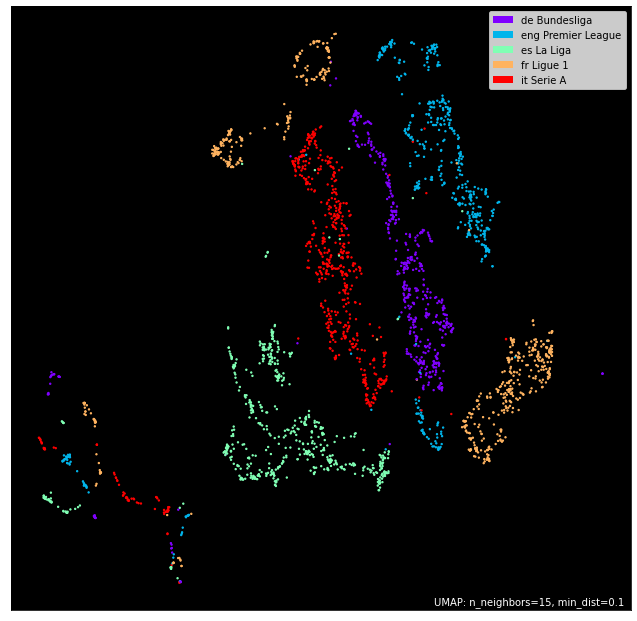

In [ ]:
player_fac = players_df['Comp'].factorize()
model_supervised = u.fit(scaled_player_data, y=player_fac[0])
umap.plot.points(model_unsupervised, labels=players_df['Comp'], theme='fire')

In order to look at past seasons, I needed to create my own player spreadsheet from past seasons on FBRef. Here is code that does the job, but no guarantees on how resilient it is. YMMV.

In [ ]:
class FBRefData(object):

  _SEASON_URLS = {
      '2020-2021': {
          'Premier League': 'https://fbref.com/en/comps/9/Premier-League-Stats',
          'La Liga':        'https://fbref.com/en/comps/12/La-Liga-Stats',
          'Ligue 1':        'https://fbref.com/en/comps/13/Ligue-1-Stats',
          'Bundesliga':     'https://fbref.com/en/comps/20/Bundesliga-Stats',
          'Serie A':        'https://fbref.com/en/comps/11/Serie-A-Stats',
      },
      '2019-2020': {
          'Premier League': 'https://fbref.com/en/comps/9/3232/2019-2020-Premier-League-Stats',
          'La Liga':        'https://fbref.com/en/comps/12/3239/2019-2020-La-Liga-Stats',
          'Ligue 1':        'https://fbref.com/en/comps/13/3243/2019-2020-Ligue-1-Stats',
          'Bundesliga':     'https://fbref.com/en/comps/20/3248/2019-2020-Bundesliga-Stats',
          'Serie A':        'https://fbref.com/en/comps/11/3260/2019-2020-Serie-A-Stats',
      },
      '2018-2019': {
          'Premier League': 'https://fbref.com/en/comps/9/1889/2018-2019-Premier-League-Stats',
          'La Liga':        'https://fbref.com/en/comps/12/1886/2018-2019-La-Liga-Stats',
          'Ligue 1':        'https://fbref.com/en/comps/13/2104/2018-2019-Ligue-1-Stats',
          'Bundesliga':     'https://fbref.com/en/comps/20/2109/2018-2019-Bundesliga-Stats',
          'Serie A':        'https://fbref.com/en/comps/11/1896/2018-2019-Serie-A-Stats',
      },
  }

  @classmethod
  def get_seasons(self):
    return list(self._SEASON_URLS.keys())

  @classmethod
  def get_urls(self, season):
    return self._SEASON_URLS[season]

  @classmethod
  def get_player_stats(self, season):
    season_urls = self._SEASON_URLS[season]
    player_stats_dfs = []
    for league_name, url in season_urls.items():
      fbref_league = FBRefLeague(league_name, url)
      league_df = fbref_league.get_league_player_stats()
      player_stats_dfs.append(league_df)
      # https://twitter.com/fbref/status/1285680660976467971
      time.sleep(10)
    player_stats_df = player_stats_dfs[0]
    for i in range(1, len(player_stats_dfs)):
      player_stats_df = pd.concat([player_stats_df, player_stats_dfs[i]])
    return player_stats_df.reset_index(drop=True)


class FBRefLeague(object):

  _FBREF_DOMAIN_HOST = 'https://fbref.com'
  _FBREF_TEAM_TABLE_INDICIES = OrderedDict({
      'Standard Stats': 0,
      'Shooting': 4,
      'Passing': 5,
      'Pass Types': 6,
      'Goal and Shot Creation': 7,
      'Defensive Actions': 8,
      'Possession': 9,
      'Playing Time': 10,
      'Miscellaneous Stats': 11,
  })
  _COLUMN_SLICES = {
      'Standard Stats': 0,          # Use the whole table
      'Shooting': 5,                # Start at the "Standard" column group
      'Passing': 5,                 # Start at the "Total" column group
      'Pass Types': 5,              # Start at the "Pass Types" column group
      'Goal and Shot Creation': 5,  # Start at the "SCA" column group
      'Defensive Actions': 5,       # Start at the "Tackles" column group
      'Possession': 5,              # Start at the "Touches" column group
      'Playing Time': 12,           # Start at the "Subs" column group
      'Miscellaneous Stats': 5,     # Start at the "Performance" column group
  }

  def __init__(self, league_name, url, save_dir='/tmp/fbref'):
    self.league_name = league_name
    self.url = url
    self.league_tbls = pd.read_html(self.url)
    self.team_names = np.sort(self.league_tbls[0]['Squad'].values)
    self.raw_page = requests.get(self.url)
    self.page = BeautifulSoup(self.raw_page.content, 'html.parser')
    if not os.path.exists(save_dir):
      os.makedirs(save_dir)
    self.save_dir = save_dir

  def get_team_urls(self):
    team_urls = {}
    for team_name in self.team_names:
      anchors = self.page.find_all('a', string=team_name)
      a = statistics.mode(anchors)
      team_urls[team_name] = f'{self._FBREF_DOMAIN_HOST}{a.attrs["href"]}'
    return team_urls

  def get_last_row_index(self, df):
    # Get the index of the first row where a player has zero matches played.
    # All rows after and including this index will be ignored.
    return df.loc[df['Playing Time', 'MP'] == 0].index[0]

  def compile_team_tbls(self, team_tbls, team_name):
    last_row_index = self.get_last_row_index(team_tbls[0])
    tbls = []
    for tbl_name, idx in self._FBREF_TEAM_TABLE_INDICIES.items():
      df = team_tbls[idx]
      if 'Matches' in df.columns.get_level_values(1):
        df = df.drop(columns='Matches', level=1)
      col_slice = self._COLUMN_SLICES[tbl_name]
      df = df.iloc[:, col_slice:]
      df = df.loc[df.index < last_row_index]
      tbls.append(df)
    # Make the first column the team (Squad) name.
    team_df = pd.DataFrame([team_name] * len(tbls[0]),
                           columns=[[''], ['Squad']],
                           index=tbls[0].index)
    for tbl in tbls:
      team_df = pd.concat([team_df, tbl], axis=1)
    file_name = f'{self.league_name}_{team_name}'.replace(' ', '_')
    # Save each team DataFrame to a CSV file in case there is an
    # exception during execution, so they can be reloaded again.
    team_df.to_csv(f'{self.save_dir}/{file_name}.csv')
    return team_df

  def get_team_tbls(self, team_urls, team_filter):
    team_dfs = []
    for team_name in self.team_names:
      if team_filter and team_name not in team_filter:
        continue
      team_url = team_urls[team_name]
      team_tbls = pd.read_html(team_url)
      team_df = self.compile_team_tbls(team_tbls, team_name)
      team_dfs.append(team_df)
      # https://twitter.com/fbref/status/1285680660976467971
      time.sleep(10)
    return team_dfs

  def clean_league_tbl(self, league_tbl):
    league_tbl.fillna(0, inplace=True)
    new_col_tuples = []
    for col in league_tbl.columns:
      if col[0].startswith('Unnamed'):
        new_col_tuples.append(('', col[1]))
      else:
        new_col_tuples.append(col)
    new_cols = pd.MultiIndex.from_tuples(new_col_tuples)
    league_tbl.columns = new_cols
    return league_tbl

  def compile_league_tbl(self, team_tbls):
    league_df = team_tbls[0]
    for i in range(1, len(team_tbls)):
      league_df = pd.concat([league_df, team_tbls[i]])
    league_df.reset_index(inplace=True, drop=True)
    league_col = pd.DataFrame([self.league_name] * len(league_df),
                              columns=[[''], ['Comp']],
                              index=league_df.index)
    league_tbl = pd.concat([league_col, league_df], axis=1)
    return self.clean_league_tbl(league_tbl)

  def get_league_player_stats(self, team_filter=None):
    team_urls = self.get_team_urls()
    team_tbls = self.get_team_tbls(team_urls, team_filter)
    league_tbl = self.compile_league_tbl(team_tbls)
    return league_tbl


In [ ]:
player_stats_1819 = FBRefData.get_player_stats('2018-2019')
player_stats_1819.head()

... Aerial Duels            
             Comp    Squad                     Player  ...          Won  Lost  Won%
0  Premier League  Arsenal                 Bernd Leno  ...          0.0   0.0   0.0
1  Premier League  Arsenal           Shkodran Mustafi  ...        100.0  57.0  63.7
2  Premier League  Arsenal  Pierre-Emerick Aubameyang  ...         26.0  76.0  25.5
3  Premier League  Arsenal               Granit Xhaka  ...         47.0  45.0  51.1
4  Premier League  Arsenal        Alexandre Lacazette  ...         32.0  88.0  26.7

[5 rows x 188 columns]

Now with player data from the 2018-2019 season, we can see a few players clustered with leagues other than the ones they are currently playing in. A quick look at player outliers (by hovering over the points in the plot) shows some interesting player alignments, such as Alexis Sánchez and Mario Mandžukić fitting in more with the German Bundesliga. The only player I can find however, which can give us an indication whether the player/league cluster is aligned correctly is Arturo Vidal, who is clustered with Serie A. Vidal did transfer to Milan two years after these stats were collected, and arguably was able to contribute.


In [ ]:
past_player_stats = player_stats_1819.iloc[:, 5:]
scaled_past_player_stats = StandardScaler().fit_transform(past_player_stats)
# The new DataFrame is multi-indexed, so the column needs
# to be squeezed to get a Series.
comps_col = player_stats_1819[[('', 'Comp')]].squeeze()
comps_fac = comps_col.factorize()
# The hover_data param requires a single index DataFrame
players_col = player_stats_1819[[('', 'Player')]]
players_col.columns = players_col.columns.get_level_values(1)
model_supervised_past = u.fit(scaled_past_player_stats, y=comps_fac[0])
# Make an interactive plot to see player names on hover
umap.plot.output_notebook()
ip = umap.plot.interactive(model_supervised_past, labels=comps_col, theme='fire', hover_data=players_col)
umap.plot.show(ip)

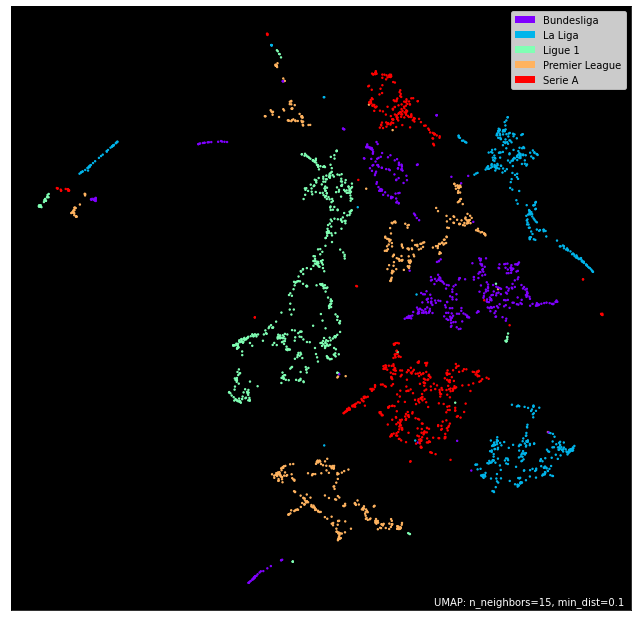

In [ ]:
# Here is a plot with color legend since the
# interactive chart doesn't display a legend.
umap.plot.points(model_supervised_past, labels=comps_col, theme='fire')

In [ ]:
# BTW, run this if you want to save the DataFrame to CSV
player_stats_1819.to_csv('player_stats.csv')